In [1]:
import os, subprocess, sys
from pathlib import Path
import numpy as np
import collections

In [2]:
target = "drd3"

In [3]:
flexi_path = f"/root/autodl-tmp/lbvs/test_dude_flexi_final/{target}/docking_test/lib/"
rigid_path = f"/root/autodl-tmp/lbvs/test_dude_rigid_final/{target}/docking_test/lib/"

In [4]:
rigid_lib_paths = [path.replace("./", rigid_path) 
                    for path in 
                       list(subprocess.check_output("find . -name '*best_position.pdbqt' -type f", shell=True, cwd=rigid_path).
                         decode(sys.stdout.encoding).split("\n"))][0:-1]

In [5]:
flexi_lib_paths = [path.replace("./", flexi_path) 
                    for path in 
                       list(subprocess.check_output("find . -name '*best_position.pdbqt' -type f", shell=True, cwd=flexi_path).
                         decode(sys.stdout.encoding).split("\n"))][0:-1]

In [6]:
ref_ind = [flexi_lib_paths.index(i) for i in flexi_lib_paths if not Path(i).stem.startswith("ZINC") and not Path(i).stem.startswith("CHEMBL")][0]
with open(flexi_lib_paths[ref_ind], "r") as tmp:
    lines = tmp.readlines()
    ref_torsion = int(lines[15].split()[1])
    
del rigid_lib_paths[ref_ind]
del flexi_lib_paths[ref_ind]
ref_torsion

7

In [7]:
actives_ind = [flexi_lib_paths.index(i) for i in flexi_lib_paths if Path(i).stem.startswith("CHEMBL")]
actives_torsion = []
for ind in actives_ind:
    with open(flexi_lib_paths[ind], "r") as tmp:
        lines = tmp.readlines()
        actives_torsion.append(int(lines[15].split()[1]))

In [8]:
decoys_ind = [flexi_lib_paths.index(i) for i in flexi_lib_paths if not Path(i).stem.startswith("CHEMBL")]
decoys_torsion = []
for ind in decoys_ind:
    with open(flexi_lib_paths[ind], "r") as tmp:
        lines = tmp.readlines()
        decoys_torsion.append(int(lines[15].split()[1]))

In [9]:
all_torsion = []
for file in flexi_lib_paths:
    with open(file, "r") as tmp:
        lines = tmp.readlines()
        all_torsion.append(int(lines[15].split()[1]))

In [10]:
actives_dict = dict(collections.Counter(actives_torsion))
{k: round(actives_dict[k] / len(actives_torsion), 3) for k in actives_dict}
actives_density = dict(collections.OrderedDict(sorted({k: round(actives_dict[k] / len(actives_torsion), 3) for k in actives_dict}.items())))

In [11]:
decoys_dict = dict(collections.Counter(decoys_torsion))
{k: round(decoys_dict[k] / len(decoys_torsion), 5) for k in decoys_dict}
decoys_density = dict(collections.OrderedDict(sorted({k: round(decoys_dict[k] / len(decoys_torsion), 3) for k in decoys_dict}.items())))

In [12]:
lib_rbonds = []
lib_names = []
for lig in flexi_lib_paths:
    try:
        with open(lig, "r") as tmp:
            lines = tmp.readlines()
            lib_rbonds.append(int(lines[15].split()[1]))
            lib_names.append(Path(lig).stem.replace('_best_position', ''))
    except:
        pass

In [13]:
flexi_scores = []
for lig in flexi_lib_paths:
    with open(lig, "r") as tmp:
        lines = tmp.readlines()
        flexi_scores.append(float(lines[3].replace("=", "").split()[-3]))
flexi_scores = np.array(flexi_scores)

In [14]:
rigid_scores = []
for lig in rigid_lib_paths:
    with open(lig, "r") as tmp:
        lines = tmp.readlines()
        rigid_scores.append(float(lines[3].replace("=", "").split()[-3]))
rigid_scores = np.array(rigid_scores)

In [15]:
dict2 = dict(collections.Counter(lib_rbonds))

In [16]:
good_inds = []
if len(rigid_scores) == len(flexi_scores):
    for i in range(len(rigid_scores)):
        if rigid_scores[i] - flexi_scores[i] > 10:
            good_inds.append(i)

In [17]:
dict1 = dict(collections.Counter(np.array(lib_rbonds)[good_inds]))

In [18]:
d = {k: round((dict1[k] / dict2[k]),3) for k in dict1}

In [19]:
od = collections.OrderedDict(sorted(d.items()))

In [20]:
od

OrderedDict([(1, 0.054),
             (2, 0.188),
             (3, 0.37),
             (4, 0.599),
             (5, 0.753),
             (6, 0.864),
             (7, 0.906),
             (8, 0.972),
             (9, 0.986),
             (10, 1.0),
             (11, 1.0),
             (12, 1.0),
             (13, 1.0),
             (14, 1.0)])

In [21]:
actives_density

{0: 0.021,
 1: 0.021,
 3: 0.042,
 4: 0.083,
 5: 0.083,
 6: 0.229,
 7: 0.167,
 8: 0.167,
 9: 0.167,
 11: 0.021}

In [22]:
decoys_density

{0: 0.004,
 1: 0.011,
 2: 0.044,
 3: 0.076,
 4: 0.109,
 5: 0.136,
 6: 0.173,
 7: 0.166,
 8: 0.112,
 9: 0.082,
 10: 0.044,
 11: 0.021,
 12: 0.012,
 13: 0.008,
 14: 0.002}

In [23]:
# actives_score = 0
# for keys, values in actives_density.items():
#     # if keys <= ref_torsion:
#         try:
#             actives_score += values * od.get(keys)
#         except:
#             actives_score += 0

In [24]:
# decoys_score = 0
# for keys, values in decoys_density.items():
#     # if keys <= ref_torsion:
#         try:
#             decoys_score += values * od.get(keys)
#         except:
#             decoys_score += 0
# decoys_score

In [25]:
# rigid_scores - flexi_scores

In [26]:
# len(all_torsion) == len(rigid_scores - flexi_scores)

In [27]:
score_change = {k: np.mean((rigid_scores - flexi_scores)[np.where(np.array(lib_rbonds)==k)[0]]) for k in d.keys()}

In [28]:
sorted_score_change = collections.OrderedDict(sorted(score_change.items()))

In [29]:
sorted_score_change

OrderedDict([(1, 3.501621621621622),
             (2, 5.462013422818791),
             (3, 9.035534351145037),
             (4, 12.544598930481284),
             (5, 17.063032258064517),
             (6, 20.440748752079866),
             (7, 23.69314136125654),
             (8, 26.98570694087404),
             (9, 32.03486013986014),
             (10, 35.815298013245034),
             (11, 39.59178082191781),
             (12, 41.822500000000005),
             (13, 45.561428571428564),
             (14, 46.82125)])

In [30]:
actives_score = 0
for keys, values in actives_density.items():
    # if keys > ref_torsion:
        try:
            actives_score += values * sorted_score_change.get(keys) * od.get(keys)
        except:
            actives_score += 0
actives_score

19.95040921127194

In [31]:
decoys_score = 0
for keys, values in decoys_density.items():
    # if keys > ref_torsion:
        try:
            decoys_score += values * sorted_score_change.get(keys) * od.get(keys)
        except:
            decoys_score += 0
decoys_score

18.381613616977113

In [32]:
actives_score/decoys_score

1.0853459128770881

In [113]:
import os, subprocess, sys
from pathlib import Path
import numpy as np
import collections
flexi_path = f"/root/autodl-tmp/lbvs/test_dude_flexi_final/"
rigid_path = f"/root/autodl-tmp/lbvs/test_dude_rigid_final/"

In [109]:
rigid_lib_ranked_file = [path.replace("./", rigid_path) 
                            for path in 
                               list(subprocess.check_output("find . -name 'ranked.txt' -type f", shell=True, cwd=rigid_path).
                                 decode(sys.stdout.encoding).split("\n"))][0:-1]
rigid_lib_paths = []
for file in rigid_lib_ranked_file:
    with open(file, "r") as tmp:
        lines = tmp.readlines()
        targets = [file.replace("ranked.txt", f"lib/{i.split()[0]}/{i.split()[0]}_best_position.pdbqt") for i in lines]
        rigid_lib_paths += targets

In [114]:
flexi_lib_ranked_file = [path.replace("./", flexi_path) 
                            for path in 
                               list(subprocess.check_output("find . -name 'ranked.txt' -type f", shell=True, cwd=flexi_path).
                                 decode(sys.stdout.encoding).split("\n"))][0:-1]
flexi_lib_paths = []
for file in flexi_lib_ranked_file:
    with open(file, "r") as tmp:
        lines = tmp.readlines()
        targets = [file.replace("ranked.txt", f"lib/{i.split()[0]}/{i.split()[0]}_best_position.pdbqt") for i in lines]
        flexi_lib_paths += targets

In [73]:
all_torsion = []
for file in flexi_lib_paths:
    with open(file, "r") as tmp:
        lines = tmp.readlines()
        all_torsion.append(int(lines[15].split()[1]))

In [74]:
lib_rbonds = []
lib_names = []
for lig in flexi_lib_paths:
    try:
        with open(lig, "r") as tmp:
            lines = tmp.readlines()
            lib_rbonds.append(int(lines[15].split()[1]))
            lib_names.append(Path(lig).stem.replace('_best_position', ''))
    except:
        pass

In [202]:
flexi_scores = []
for file in flexi_lib_ranked_file:
    score_file = file.replace("ranked.txt", "scores.txt")
    with open(score_file, "r") as tmp:
        lines = tmp.readlines()
        sc = [float(i.split()[0]) for i in lines]
        flexi_scores += sc
flexi_scores = np.array(flexi_scores)
flexi_scores = 1 + 1/flexi_scores

In [143]:
flexi_lib_paths = np.array(flexi_lib_paths)

In [144]:
list(flexi_lib_paths[np.where(flexi_scores>0)])[::-1]

['/root/autodl-tmp/lbvs/test_dude_flexi_final/wee1/docking_test/lib/CHEMBL271715/CHEMBL271715_best_position.pdbqt',
 '/root/autodl-tmp/lbvs/test_dude_flexi_final/aa2ar/docking_test/lib/CHEMBL177229/CHEMBL177229_best_position.pdbqt']

In [203]:
rigid_scores = []
for file in rigid_lib_ranked_file:
    score_file = file.replace("ranked.txt", "scores.txt")
    with open(score_file, "r") as tmp:
        lines = tmp.readlines()
        sc = [float(i.split()[0]) for i in lines]
        rigid_scores += sc
rigid_scores = np.array(rigid_scores)
rigid_scores = 1 + 1/rigid_scores

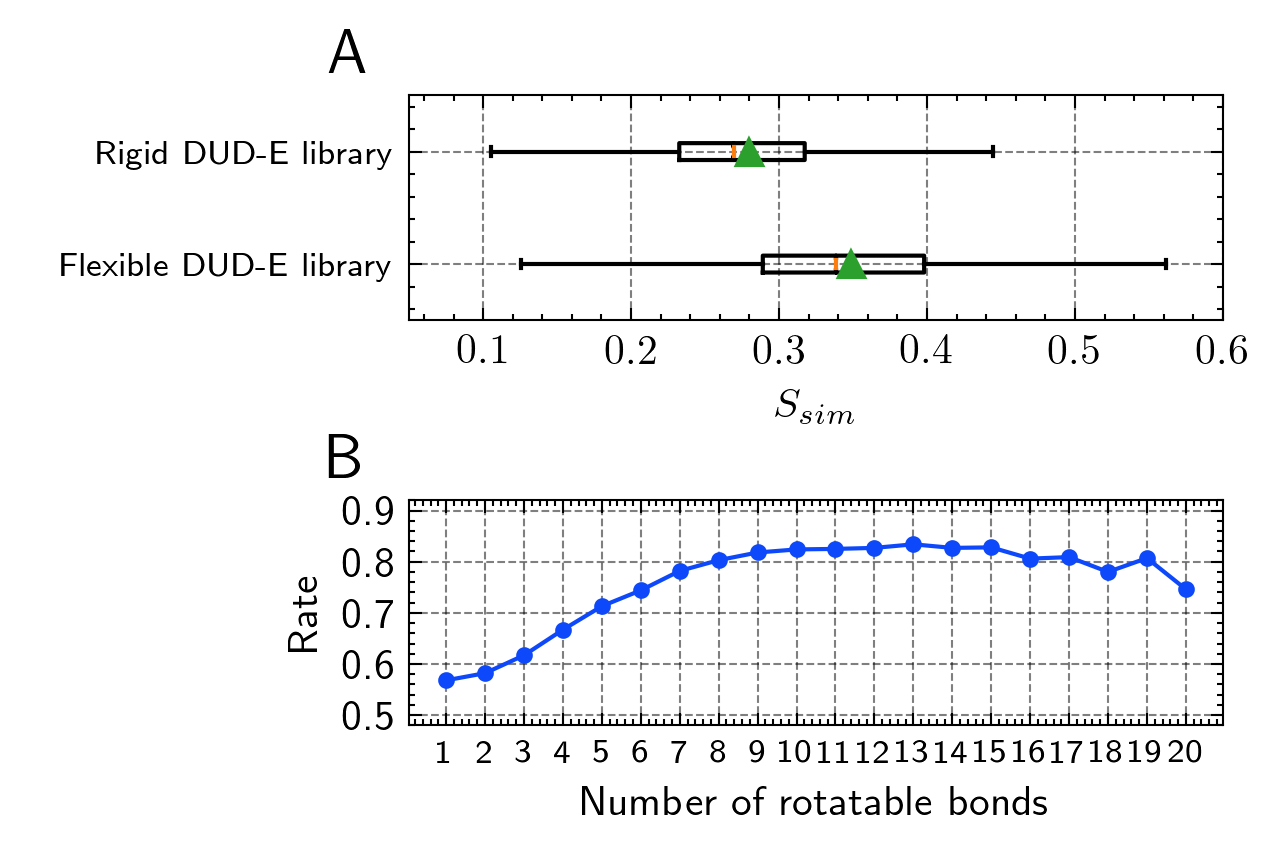

In [295]:
import string
with plt.style.context(['science', "high-vis", "grid"]):
    fig, ax = plt.subplots(2,1, dpi=300)
    ax[0].boxplot([flexi_scores, rigid_scores], showfliers=False, notch=True, showmeans=True, vert=False)
    # ax[0].autoscale(tight=True)
    ax[0].set_xlim(left=0.05, right=0.6)
    ax[0].set(xlabel="$S_{sim}$")
    ax[0].set_yticklabels(['Flexible DUD-E library', 'Rigid DUD-E library'], fontsize=8)
    
    ax[1].plot(list(od)[1:21],list(od.values())[1:21], ".-")
    ax[1].set_ylim(bottom=0.48, top=0.92)
    ax[1].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9])
    ax[1].set_yticklabels([0.5, 0.6, 0.7, 0.8, 0.9])
    ax[1].set_xticks([i for i in range(1,21)], fontsize=8)
    ax[1].set_xticklabels([i for i in range(1,21)], fontsize=8)
    ax[1].set(xlabel="Number of rotatable bonds", ylabel="Rate")
    for n, a in enumerate(ax):   
        a.text(-0.1, 1.1, string.ascii_uppercase[n], transform=a.transAxes, 
                size=15, weight='bold')
    plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.8)
    # ax[1].set_ylabel("Percentage")
    # plt.show()
    plt.savefig("flexi_vs_rigid.svg")
    # ax2 = ax.twiny()
    # ax.set_xticks([1,2])
    # ax2.set_xticks([1,2])
    # ax.boxplot(flexi_scores, positions=[1], showfliers=False)
    # ax2.boxplot(rigid_scores, positions=[2], showfliers=False)

In [208]:
import scipy.stats as st
st.norm.interval(alpha=0.95, loc=np.mean(flexi_scores), scale=st.sem(rigid_scores))

(0.3486143013548126, 0.34884444262636044)

In [209]:
st.t.interval(alpha=0.95, df=len(rigid_scores)-1, loc=np.mean(rigid_scores), scale=st.sem(rigid_scores)) 

(0.2796918044008143, 0.2799219458679648)

In [228]:
np.mean(rigid_scores)-np.mean(flexi_scores)

-0.06892249685619695

In [229]:
[np.mean(rigid_scores), np.mean(flexi_scores)]

[0.27980687513438957, 0.3487293719905865]

In [222]:
good_inds = []
if len(rigid_scores) == len(flexi_scores):
    for i in range(len(rigid_scores)):
        if rigid_scores[i] - flexi_scores[i] < -0.05:
            good_inds.append(i)

In [223]:
dict2 = dict(collections.Counter(lib_rbonds))
dict1 = dict(collections.Counter(np.array(lib_rbonds)[good_inds]))

In [224]:
d = {k: round((dict1[k] / dict2[k]),3) for k in dict1}

In [225]:
od = collections.OrderedDict(sorted(d.items()))

In [291]:
od

OrderedDict([(0, 0.548),
             (1, 0.568),
             (2, 0.582),
             (3, 0.617),
             (4, 0.667),
             (5, 0.713),
             (6, 0.744),
             (7, 0.782),
             (8, 0.803),
             (9, 0.818),
             (10, 0.824),
             (11, 0.825),
             (12, 0.827),
             (13, 0.834),
             (14, 0.827),
             (15, 0.828),
             (16, 0.806),
             (17, 0.809),
             (18, 0.78),
             (19, 0.807),
             (20, 0.746),
             (21, 0.759),
             (22, 0.805),
             (23, 0.763),
             (24, 0.726),
             (25, 0.87),
             (26, 0.783),
             (27, 1.0),
             (28, 0.75)])

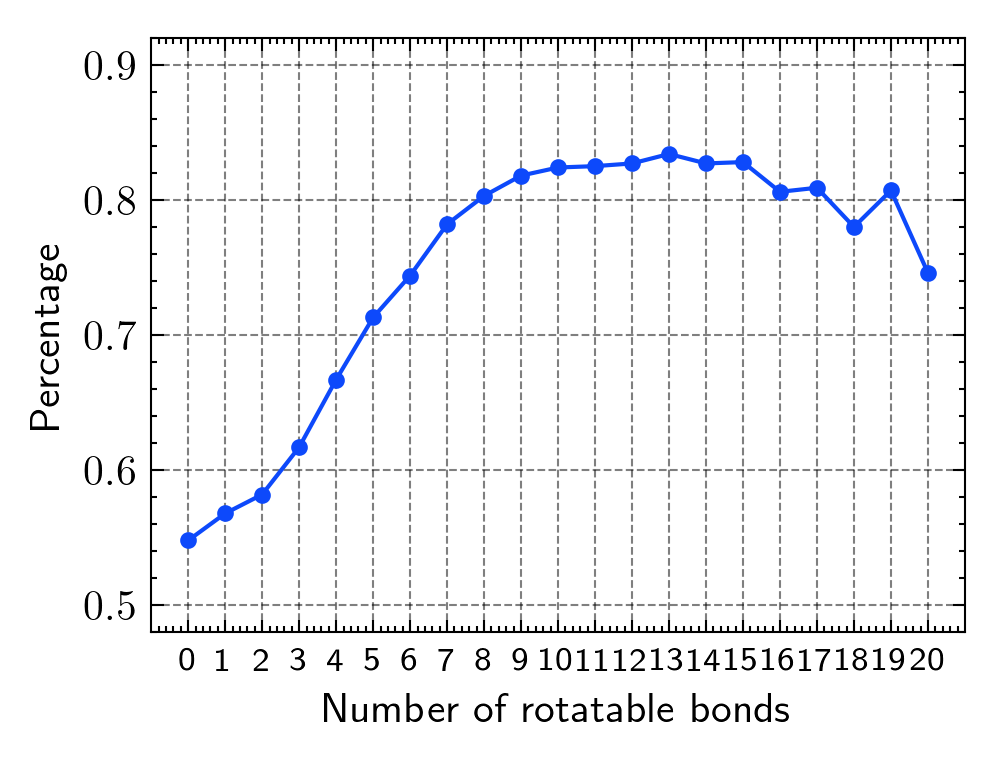

In [251]:
with plt.style.context(['science', "high-vis", "grid"]):
    fig, ax = plt.subplots(dpi=300, sharex=True, sharey=True)
    ax.plot(list(od)[0:21],list(od.values())[0:21], ".-")
    ax.set_ylim(bottom=0.48, top=0.92)
    ax.set_xticks([i for i in range(21)])
    ax.set_xticklabels([i for i in range(21)], fontsize=8)
    ax.set_xlabel("Number of rotatable bonds")
    ax.set_ylabel("Percentage")